# 1 - OPES expanded
We use [OPES_EXPANDED](https://www.plumed.org/doc-v2.8/user-doc/html/_o_p_e_s__e_x_p_a_n_d_e_d.html) to sample expanded (or generalized) ensembles.
</br>
The system is alanine dipeptide in vacuum (ala2).

In [1]:
root_path = '../' #change this if you move the nootebook somewhere else

import numpy as np
import plumed

import sys
sys.path.append(root_path + 'scripts') #dirty way to import our script
from calcFES import calcFES, calcDeltaF, calcESS

In [2]:
#reuse same plumed kernel, to avoid multiple warnings
PLUMED_KERNEL=plumed.Plumed()
from functools import partial
plumed.read_as_pandas = partial(plumed.read_as_pandas, kernel=PLUMED_KERNEL)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mi/minvernizzi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


In [3]:
#plot-related stuff
import matplotlib.pyplot as plt
from IPython.display import clear_output

#set bigger font sizes
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIG_SIZE = 15
plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

try:
# https://github.com/luigibonati/fessa-color-palette/blob/master/fessa.py
    import fessa
    plt.set_cmap('fessa')
except:
    pass # no big deal

<Figure size 432x288 with 0 Axes>

In [4]:
#useful constants for our simulations
KB = 0.0083144621
T0 = 300
BETA0 = 1/(KB*T0)
KBT = KB*T0

## 1.1 - Multithermal simulations
We start with a multithermal expansion, that will result in the typical ensemble sampled by parallel tempering.
Notice that in order to achieve this, we only need a bias potential that is a function of the potential energy of the system.

It is always good to refer to the plumed documentation to better understand the input files and the possible options. Here we use [ECV_MULTITHERMAL](https://www.plumed.org/doc-v2.8/user-doc/html/_e_c_v__m_u_l_t_i_t_h_e_r_m_a_l.html) and [OPES_EXPANDED](https://www.plumed.org/doc-v2.8/user-doc/html/_o_p_e_s__e_x_p_a_n_d_e_d.html).

In [5]:
folder = root_path + '1-opes_expanded/multithermal/'
# folder = root_path + '1-opes_expanded/multithermal-walkers/'
# folder = root_path + '1-opes_expanded/multithermal-2/'
# folder = root_path + '1-opes_expanded/multithermal-100/'

try:
    colvar = plumed.read_as_pandas(folder+'COLVAR')
except: # are you using multiple walkers?
    # !cat {folder}?/COLVAR* > {folder}COLVAR
    !sort -gk1 {folder}?/COLVAR* > {folder}COLVAR
    colvar = plumed.read_as_pandas(folder+'COLVAR')
    !rm {folder}COLVAR
time = colvar['time'].to_numpy()/1000 #convert from ps to ns
deltaFs = plumed.read_as_pandas(folder+'DELTAFS')

#compare to another run
folder_old = root_path + '1-opes_expanded/multithermal/'
print_old = (folder_old != folder)
if print_old:
    deltaFs_old = plumed.read_as_pandas(folder_old+'DELTAFS')

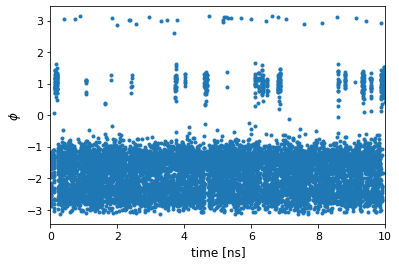

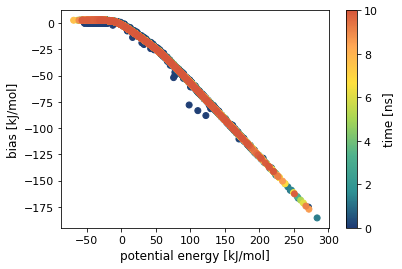

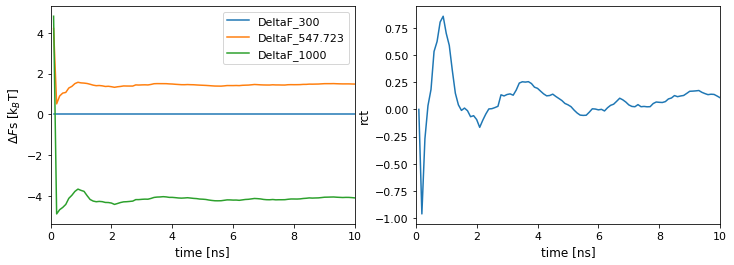

In [6]:
#plot phi
plt.plot(time, colvar['phi'], '.')
plt.ylabel('$\phi$')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])
plt.show()

#plot bias
plt.scatter(colvar['ene'], colvar['opes.bias'], c=time)
plt.ylabel('bias [kJ/mol]')
plt.xlabel('potential energy [kJ/mol]')
plt.colorbar(label='time [ns]')
plt.show()

#plot all deltaFs
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
if print_old:
    for col in deltaFs_old:
        if col != 'time' and col != 'rct':
            axs[0].plot(deltaFs_old['time']/1000, deltaFs_old[col]/KBT, '--')
for col in deltaFs:
    if col != 'time' and col != 'rct':
        axs[0].plot(deltaFs['time']/1000, deltaFs[col]/KBT, label=col)
axs[0].set_ylabel('$\Delta F$s [k$_B$T]')
axs[0].legend()
#plot rct
if print_old:
    axs[1].plot(deltaFs_old['time']/1000, deltaFs_old['rct'], '--')
axs[1].plot(deltaFs['time']/1000, deltaFs['rct'])
plt.ylabel('rct')
plt.setp(axs, xlabel='time [ns]', xlim=(time[0], time[-1]))
plt.show()

All the free energy differences, "DeltaF" are referred to the unbiased system, that in our case has T0 = 300 K. So, we expect DeltaF_300 = 0 always. It's nice to see that the other two estimates soon stabilize. This means that the bias has reached a quasi-static regime.
</br> A similar infromation is given by `rct`, that converges to a fixed value as the simulation converge. 

**More in detail:**
The DeltaF printed in the file are those defined in Eq.(5) and (11) of Ref.[68](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.041034). We can rewrite these general equations in a more explicit way for our specific case:
$$\Delta F (T) = - k_B T_0\log \frac{Z_T}{Z_{T_0}} \approx - k_B T_0 \log \frac{\langle w_T(U) w_V(U)\rangle}{\langle w_V(U)\rangle}$$
where the ensemble average is over the biased target distribution, and $w_T = e^{\left(\frac{1}{k_BT_0}-\frac{1}{k_BT}\right)U} = e^{\frac{1-T_0/T}{k_BT_0}U}$ with $U$ the potential energy (our CV), and $w_V(U)=e^{\frac{1}{k_BT_0}V(U)}$, the usual bias reweighting term.
</br>These weights combined $w_T(U) w_V(U)$ can be used to reweight our multithermal simulation at any temperature in the chosen range.
</br>Finally the `rct` term is defined as for metadynamics, $c(t)=-k_B T_0\log \langle w_V(U)\rangle$

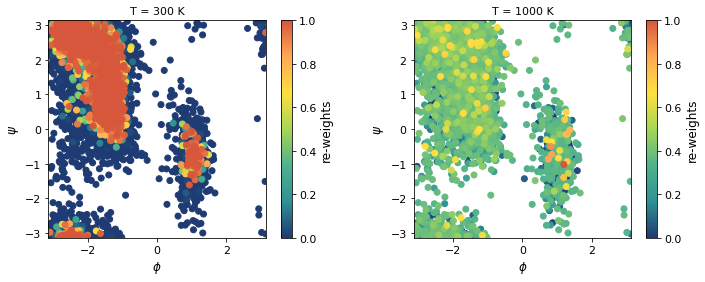

In [7]:
#plot phi-psi with weights for reweighting
def plot_phi_psi_weights(ax, logweights, colvar=colvar, sort=True):
    if sort:
        indexes = np.argsort(logweights)
    else:
        indexes = np.arange(len(logweights))
    sc = ax.scatter(colvar['phi'][indexes], colvar['psi'][indexes], c=np.exp(logweights[indexes]-max(logweights)))
    ax.set_aspect('equal')
    ax.set_ylabel('$\psi$')
    ax.set_xlabel('$\phi$')
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlim(-np.pi,np.pi)
    plt.colorbar(sc, ax=ax, label='re-weights')
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
ax1.set_title('T = 300 K')
logweights = colvar['opes.bias']/KBT
plot_phi_psi_weights(ax1, logweights)

temp2 = 1000 #150
ax2.set_title(f'T = {temp2} K')
logweights = (colvar['opes.bias']+(1-T0/temp2)*colvar['ene'])/KBT
plot_phi_psi_weights(ax2, logweights)
plt.show()

In [8]:
%%time
#now calculate the actual free energy surface (FES)

nbins = 75
grid = np.linspace(-np.pi, np.pi, nbins)
X,Y = np.meshgrid(grid, grid)

transient = 0
bandwidth = (0.15, 0.15)
cvs = (colvar['phi'][transient:], colvar['psi'][transient:])

print('calculating 1 of 2...', end='\r')
logweights = colvar['opes.bias'][transient:]/KBT
fes = calcFES((X,Y), bandwidth, cvs, logweights, periodic=True)
deltaF = calcDeltaF(fes, X<0) #basinA is x<0, basinB is x>0

print('calculating 2 of 2...', end='\r')
temp2 = 1000
logweights = (colvar['opes.bias'][transient:]+(1-T0/temp2)*colvar['ene'][transient:])/KBT
fes_temp2 = calcFES((X,Y), bandwidth, cvs, logweights, periodic=True)
deltaF_temp2 = calcDeltaF(fes_temp2, X<0) #basinA is x<0, basinB is x>0

CPU times: user 16.3 s, sys: 5.95 ms, total: 16.3 s
Wall time: 16.3 s


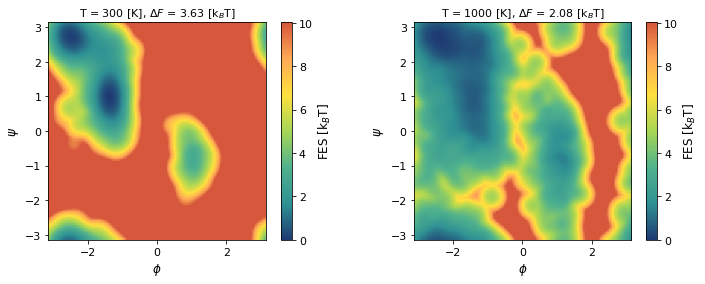

In [9]:
def plot_fes(ax, fes, max_fes=25/KBT):
    im = ax.imshow(fes, vmax=max_fes, origin='lower', extent=(-np.pi,np.pi,-np.pi,np.pi))
    ax.set_aspect('equal')
    ax.set_ylabel('$\psi$')
    ax.set_xlabel('$\phi$')
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlim(-np.pi,np.pi)
    plt.colorbar(im, ax=ax, label='FES [k$_B$T]')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
ax1.set_title(f'T = 300 [K], $\Delta F$ = {deltaF:.2f} [k$_B$T]')
plot_fes(ax1, fes)
ax2.set_title(f'T = {temp2} [K], $\Delta F$ = {deltaF_temp2:.2f} [k$_B$T]')
plot_fes(ax2, fes_temp2)
plt.show()

We can quantify the efficiency of our multithermal simulation, by plotting the **effective sample size** (ESS or $n_{\text{eff}}$) as a function of temperature:
$$ n_{\text{eff}} = \frac{\left[\sum_k^n w_k\right]^2}{\sum_k^n w_k^2}$$
where $w_k=w_T(U(x_k))w_V(U(x_k))$ are the reweighting weights. For nonuniform weights $0<n_{\text{eff}}<n$. The ratio between the effective sample size and the number of samples $n$ give us a first estimate of how good the sampling is.
However, this is only the loss in efficiency due to the importance sampling. Another efficiency loss comes from the fact that MD samples are correlated. This can be taken into account e.g. by a block average analysis. This will help you quantify if your simulation makes enough transitions between the metastable states.

OPES_EXPANDED calculates the $n_{\text{eff}}$ of the first few steps (`OBSERVATION_STEPS=100` by default) in order to automatically choose the number of `TEMP_STEPS` to use for the expansion.

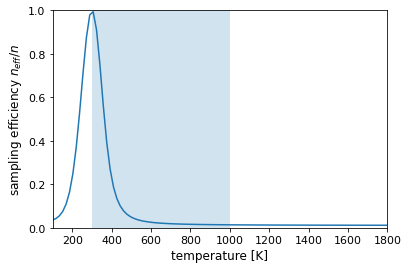

In [10]:
# calculate ESS of the initial unbiased samples
temp_min = 300
temp_max = 1000
temp_steps = 3
temps = np.linspace(100, 1800, 100)

start = len(np.where(colvar['opes.bias']==0)[0]) #only at the beginning the bias is perfectly zero
ESSs_start = np.array([calcESS(((1-T0/t)*colvar['ene'][:start])/KBT) for t in temps])

plt.plot(temps, ESSs_start/start)
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.ylim(0, 1)
plt.axvspan(temp_min, temp_max, alpha=0.2)
plt.show()

We use the full width at half maximum of this curve to estimate how many temperature steps are needed to cover the whole range.

transient = 101


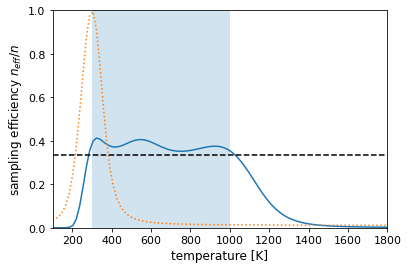

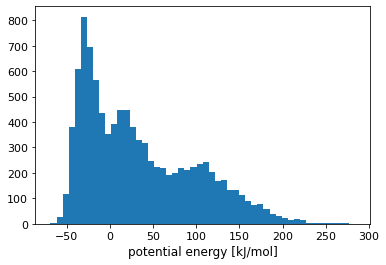

In [11]:
#plot effective sample size as a function of temperature
transient = start
print('transient =', transient)

ESSs = np.array([calcESS((colvar['opes.bias'][transient:]+(1-T0/t)*colvar['ene'][transient:])/KBT) for t in temps])

plt.plot(temps, ESSs/(len(colvar['time'][transient:])))
plt.plot(temps, ESSs_start/start, ls=':')
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.ylim(0, 1)
plt.axvspan(temp_min, temp_max, alpha=0.2)
plt.axhline(1/temp_steps, ls='--', c='k')
plt.show()

#plot the sampled energy distribution
plt.hist(colvar['ene'][transient:], bins=50)
plt.xlabel('potential energy [kJ/mol]')
plt.show()

The sampling efficiency is slightly higher than 1/3 and almost uniform over the chosen temperature range. Perfect!
What happens if we instead choose `TEMP_STEPS=2` or `TEMP_STEPS=100`?

We can also run the same simulation with regular parallel tempering, there is also a [PLUMED tutorial](https://www.plumed.org/doc-v2.8/user-doc/html/belfast-7.html) about it.
We should find a similar energy histogram and effective sample size distribution.

## 1.2 - Multiumbrella simulations
Now we want to sample the expanded ensemble obtained by combining all the different probability distribution of a multiple windows umbrella sampling simulation.
We use [ECV_UMBRELLAS_LINE](https://www.plumed.org/doc-v2.8/user-doc/html/_e_c_v__u_m_b_r_e_l_l_a_s__l_i_n_e.html).

In [12]:
folder = root_path + '1-opes_expanded/multiumbrella/'
# folder = root_path + '1-opes_expanded/multiumbrella-bis/'
# folder = root_path + '1-opes_expanded/multiumbrella-nobarrier/'
# folder = root_path + '1-opes_expanded/multiumbrella-21.3/'
# folder = root_path + '1-opes_expanded/multiumbrella-psi/'

colvar = plumed.read_as_pandas(folder+'COLVAR')
time = colvar['time'].to_numpy()/1000
deltaFs = plumed.read_as_pandas(folder+'DELTAFS')

#print a reference
folder_old = root_path + '1-opes_expanded/multiumbrella/'
print_old = (folder_old != folder)
if print_old:
    deltaFs_old = plumed.read_as_pandas(folder_old+'DELTAFS')

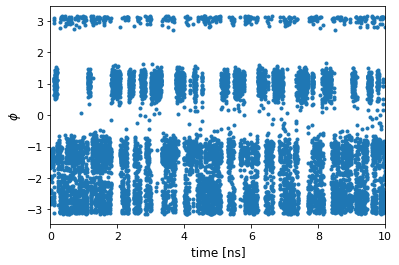

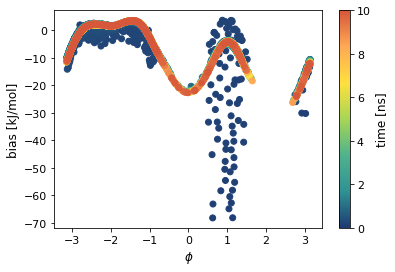

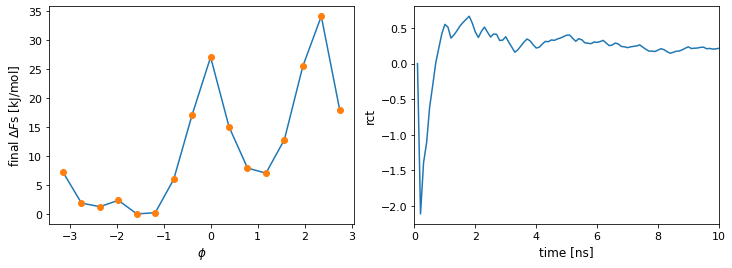

In [13]:
#plot phi
plt.plot(time, colvar['phi'], '.')
plt.ylabel('$\phi$')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])
plt.show()

#plot bias
plt.scatter(colvar['phi'], colvar['opes.bias'], c=time)
plt.ylabel('bias [kJ/mol]')
plt.xlabel('$\phi$')
plt.colorbar(label='time [ns]')
plt.show()

#plot deltaFs
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
#extract umbrella positions from the DELTAFS file, DeltaF_value
if print_old:
    phi_values_old = np.array([float(val[7:]) for val in deltaFs_old.columns[2:] if val != 'DeltaF_P0'])
    final_deltaFs_old = deltaFs_old.iloc[-1][-len(phi_values_old):]
    final_deltaFs_old -= min(final_deltaFs_old)
    axs[0].plot(phi_values_old, final_deltaFs_old, '--')
    axs[0].plot(phi_values_old, final_deltaFs_old, 'o', fillstyle='none')
phi_values = np.array([float(val[7:]) for val in deltaFs.columns[2:] if val != 'DeltaF_P0'])
final_deltaFs = deltaFs.iloc[-1][-len(phi_values):]
final_deltaFs -= min(final_deltaFs)
axs[0].plot(phi_values, final_deltaFs)
axs[0].plot(phi_values, final_deltaFs, 'o')
axs[0].set_ylabel('final $\Delta F$s [kJ/mol]')
axs[0].set_xlabel('$\phi$')
#plot rct
if print_old:
    axs[1].plot(deltaFs['time']/1000, deltaFs_old['rct'], '--')
axs[1].plot(deltaFs['time']/1000, deltaFs['rct'])
plt.ylabel('rct')
plt.setp(axs[1], xlabel='time [ns]', xlim=(time[0], time[-1]))
plt.show()

Bandwidth: 0.25, DeltaF estimate: 7.95346
Bandwidth: 0.20, DeltaF estimate: 8.26742
Bandwidth: 0.10, DeltaF estimate: 8.61222
Bandwidth: 0.05, DeltaF estimate: 8.65709


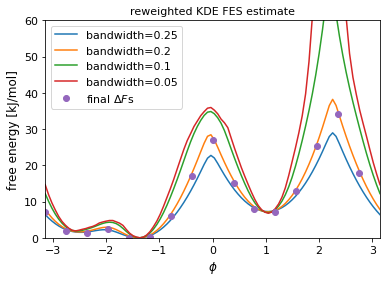

In [14]:
#reweighted FES estimate using kernel density estimate (KDE)
transient = 1000
nbins = 100
grid = np.linspace(-np.pi, np.pi, nbins)
logweights = colvar['opes.bias'][transient:]/KBT

plt.title('reweighted KDE FES estimate')
for bandwidth in [0.25, 0.2, 0.1, 0.05]:
    fes = KBT*calcFES(grid, bandwidth, colvar['phi'][transient:], logweights, periodic=True)
    print(f'Bandwidth: {bandwidth:.2f}, DeltaF estimate: {calcDeltaF(fes, grid<0, kbt=KBT):g}')
    plt.plot(grid, fes, label=f'bandwidth={bandwidth}')
plt.plot(phi_values, final_deltaFs, 'o', label='final $\Delta F$s')
plt.ylabel('free energy [kJ/mol]')
plt.xlabel('$\phi$')
plt.ylim(0, 60)
plt.xlim(-np.pi, np.pi)
plt.legend()
plt.show()

What is the marginal $p(\phi)$ of the sampled distribution? Is it flat, well-tempered, or something else?

Now let's play around with the parameters of ECV_UMBRELLAS_LINE:
- what happens if we decrease the `SIGMA`?
- what is the effect of adding a `BARRIER` estimate?
- can we still estimate the DeltaF is we set `CV_MAX=2`?

We can also reproduce [Masterclass 21.3](https://www.plumed.org/doc-master/user-doc/html/masterclass-21-3.html), where they used 32 umbrellas with a `KAPPA=200`. The equivalent here would be to set `SIGMA=1/sqrt(200)`$\approx 0.07$ and `SPACING=2*pi/32*sqrt(200)`$\approx 2.78$. But we'd better also specify a `BARRIER`...

Finally, using $\psi$ as CV we can see an example of non-converged simulation, e.g. by looking at `rct`.

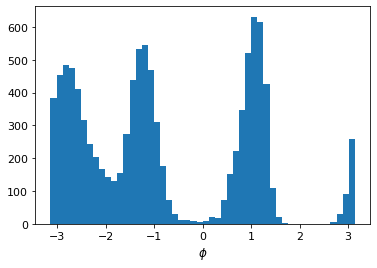

In [15]:
#marginal distribution on phi, without reweighting
plt.hist(colvar['phi'], bins=50)
plt.xlabel('$\phi$')
plt.show()

## 1.3 - Combined multithermal and multiumbrella simulations
We can combine different expansions, simply by providing more than one ECV to OPES_EXPANDED. 
Instead of a one dimensional grid of DeltaFs, there will be a multidimensional array.
</br>For example:
if we expand over 3 temperatures, and over 21 umbrella potentials, we have to estimate 3\*21=63 DeltaFs.
We can check the `alanine.log` file where this is always reported:
```
PLUMED: Action OPES_EXPANDED
PLUMED:   *   3 temperatures for ECV_MULTITHERMAL
PLUMED:   *  21 windows for ECV_UMBRELLAS_LINE
PLUMED:  ->  63 DeltaFs in total
PLUMED: Finished initialization
```

The resulting DELTAFS file can become complicated to handle, but we can store the same information also in the STATE file that reports the DeltaFs in a more readable way.

Combining these 63 ensembles with replica exchange would require 63 parallel simulations. Here instead we are free to choose how many parallel replicas we wish. We start with 3.

In [16]:
folder = root_path + '1-opes_expanded/combined-mtmu/'
# folder = root_path + '1-opes_expanded/combined-mtmu-psi/'

try:
    colvar = plumed.read_as_pandas(folder+'COLVAR')
except: # are you using multiple walkers?
    # !cat {folder}?/COLVAR* > {folder}COLVAR
    !sort -gk1 {folder}?/COLVAR* > {folder}COLVAR
    colvar = plumed.read_as_pandas(folder+'COLVAR')
    !rm {folder}COLVAR
time = colvar['time'].to_numpy()/1000
deltaFs = plumed.read_as_pandas(folder+'DELTAFS')
state = plumed.read_as_pandas(folder+'STATE')

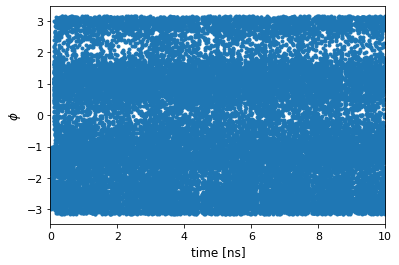

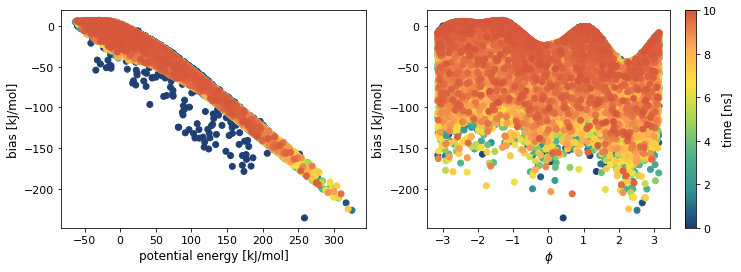

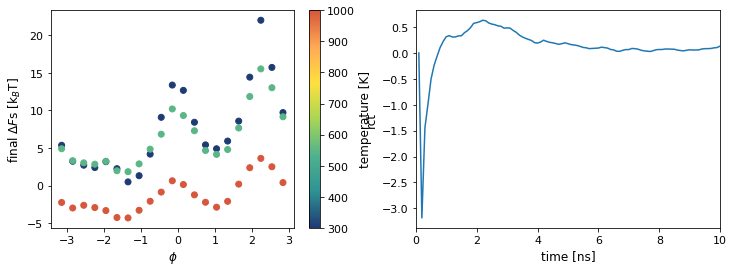

In [17]:
#plot phi
plt.plot(time, colvar['phi'], '.')
plt.ylabel('$\phi$')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])
plt.show()

#plot bias
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
axs[0].scatter(colvar['ene'], colvar['opes.bias'], c=time)
axs[0].set_xlabel('potential energy [kJ/mol]')
sc = axs[1].scatter(colvar['phi'], colvar['opes.bias'], c=time)
axs[1].set_xlabel('$\phi$')
plt.setp(axs, ylabel='bias [kJ/mol]')
plt.colorbar(sc, ax=axs[1], label='time [ns]')
plt.show()

#plot final deltaFs
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
num_deltaFs = len(deltaFs.iloc[-1][2:])
sc = axs[0].scatter(state.iloc[:num_deltaFs,1], state.iloc[:num_deltaFs,2]/KBT, c=state.iloc[:num_deltaFs,0])
axs[0].set_ylabel('final $\Delta F$s [k$_B$T]')
axs[0].set_xlabel('$\phi$')
plt.colorbar(sc, ax=axs[0], label='temperature [K]')
#plot rct
axs[1].plot(deltaFs['time']/1000, deltaFs['rct'])
plt.ylabel('rct')
plt.setp(axs[1], xlabel='time [ns]', xlim=(time[0], time[-1]))
plt.show()

T = 300.0, DeltaF estimate: 3.6386 [kBT]
T = 547.7, DeltaF estimate: 2.79974 [kBT]
T =1000.0, DeltaF estimate: 2.20324 [kBT]


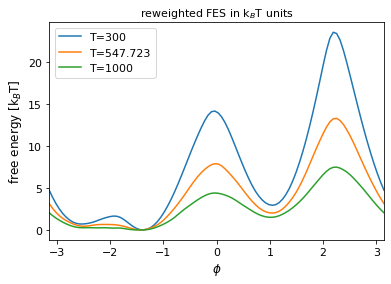

T = 300.0, DeltaF estimate: 9.07591 [kJ/mol]
T = 547.7, DeltaF estimate: 12.7501 [kJ/mol]
T =1000.0, DeltaF estimate: 18.3188 [kJ/mol]


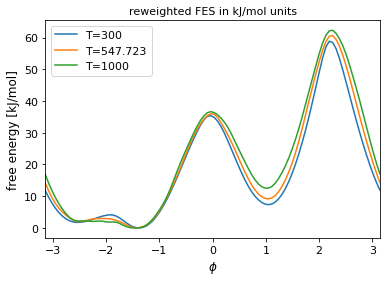

In [18]:
#1D FES
transient = 1000
grid = np.linspace(-np.pi, np.pi, 100)
bandwidth = 0.1
temps = np.unique(state['ecv_mt.ene'].iloc[:num_deltaFs])

plt.title('reweighted FES in k$_B$T units')
for t in temps:
    logweights = (colvar['opes.bias'][transient:]+(1-T0/t)*colvar['ene'][transient:])/KBT
    fes = calcFES(grid, bandwidth, colvar['phi'][transient:], logweights, periodic=True)
    print(f'T ={t:6.1f}, DeltaF estimate: {calcDeltaF(fes, grid<0):g} [kBT]')
    plt.plot(grid, fes, label=f'T={t:g}')
plt.ylabel('free energy [k$_B$T]')
plt.xlabel('$\phi$')
plt.xlim(-np.pi, np.pi)
plt.legend()
plt.show()

plt.title('reweighted FES in kJ/mol units')
for t in temps:
    kbt = KBT*t/T0
    logweights = (colvar['opes.bias'][transient:]+(1-T0/t)*colvar['ene'][transient:])/KBT
    fes = kbt*calcFES(grid, bandwidth, colvar['phi'][transient:], logweights, periodic=True)
    print(f'T ={t:6.1f}, DeltaF estimate: {calcDeltaF(fes, grid<0, kbt=kbt):g} [kJ/mol]')
    plt.plot(grid, fes, label=f'T={t:g}')
plt.ylabel('free energy [kJ/mol]')
plt.xlabel('$\phi$')
plt.xlim(-np.pi, np.pi)
plt.legend()
plt.show()

In [19]:
%%time
#now calculate the 2D free energy surface (FES)
nbins = 75
grid = np.linspace(-np.pi, np.pi, nbins)
X,Y = np.meshgrid(grid, grid)

transient = 0
bandwidth = (0.15, 0.15)
cvs = (colvar['phi'][transient:], colvar['psi'][transient:])

print('calculating 1 of 2...', end='\r')
logweights = colvar['opes.bias'][transient:]/KBT
fes = calcFES((X,Y), bandwidth, cvs, logweights, periodic=True)
deltaF = calcDeltaF(fes, X<0)

print('calculating 2 of 2...', end='\r')
temp2 = 1000
logweights = (colvar['opes.bias'][transient:]+(1-T0/temp2)*colvar['ene'][transient:])/KBT
fes_temp2 = calcFES((X,Y), bandwidth, cvs, logweights, periodic=True)
deltaF_temp2 = calcDeltaF(fes_temp2, X<0)

CPU times: user 25.2 s, sys: 615 µs, total: 25.2 s
Wall time: 25.2 s


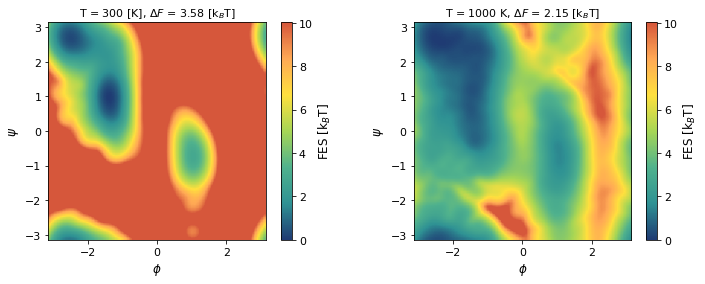

DeltaF estimate at 300K: 8.92759 [kJ/mol]


In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
ax1.set_title(f'T = 300 [K], $\Delta F$ = {deltaF:.2f} [k$_B$T]')
plot_fes(ax1, fes)
ax2.set_title(f'T = {temp2} K, $\Delta F$ = {deltaF_temp2:.2f} [k$_B$T]')
plot_fes(ax2, fes_temp2)
plt.show()
print(f'DeltaF estimate at 300K: {KBT*calcDeltaF(fes, X<0):g} [kJ/mol]')

The $\psi$ angle is known to be a bad collective variable for ala2, and we can test it with a quick multiumbrella simulation.
What happens if we run a combined multithermal-multiumbrella simulation, this time using $\psi$ instead of $\phi$?

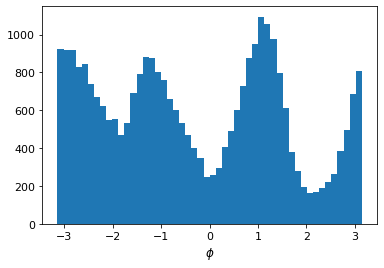

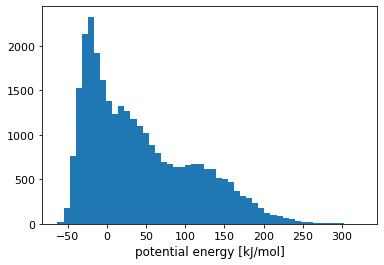

In [21]:
#marginal distribution on phi
plt.hist(colvar['phi'], bins=50)
plt.xlabel('$\phi$')
plt.show()

#marginal distribution on ene
plt.hist(colvar['ene'], bins=50)
plt.xlabel('potential energy [kJ/mol]')
plt.show()

## 1.4 - Bonus exercise
The Gaussian accellerated molecular dynamics ([GaMD](https://miaolab.ku.edu/GaMD/theory.html)) can be implemented in PLUMED using the [LOWER_WALLS](https://www.plumed.org/doc-v2.8/user-doc/html/_l_o_w_e_r__w_a_l_l_s.html) bias (but unfourtunately only using the total energy as a CV, since torsion energies are not yet available from GROMACS).
</br>
You can use a similar approach with OPES, but running an expanded ensemble of GaMD simulations with a collection of different parameters. You will need the LOWER_HALF_ONLY flag of ECV_UMBRELLAS_LINE.
How is this better than trying to sample a uniform distribution along the energy (with multiumbrellas or OPES_METAD)?

First we place only a fixed external potential, as in standard GaMD.

In [22]:
folder = root_path + '1-opes_expanded/gamd-1/'
colvar = plumed.read_as_pandas(folder+'COLVAR')
time = colvar['time'].to_numpy()/1000

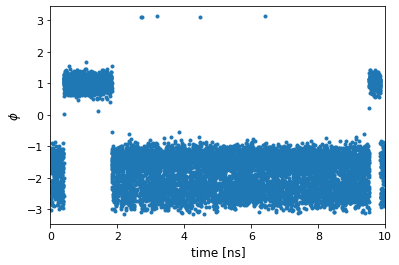

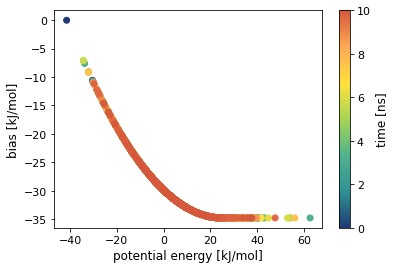

In [23]:
#plot phi
plt.plot(time, colvar['phi'], '.')
plt.ylabel('$\phi$')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])
plt.show()

#plot bias
plt.scatter(colvar['ene'], colvar['opes.bias'], c=time)
plt.ylabel('bias [kJ/mol]')
plt.xlabel('potential energy [kJ/mol]')
plt.colorbar(label='time [ns]')
plt.show()

We have transitions, but how is the effective sampling size?

transient = 0


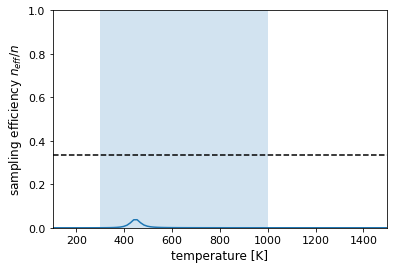

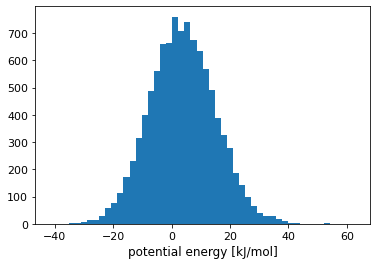

In [24]:
#plot effective sample size as a function of temperature
transient = 0
print('transient =', transient)

temp_min = 300
temp_max = 1000
temp_steps = 3
temps = np.linspace(100, 1500, 100)

ESSs = np.array([calcESS((colvar['opes.bias'][transient:]+(1-T0/t)*colvar['ene'][transient:])/KBT) for t in temps])

plt.plot(temps, ESSs/(len(colvar['time'][transient:])))
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.ylim(0, 1)
plt.axvspan(temp_min, temp_max, alpha=0.2)
plt.axhline(1/temp_steps, ls='--', c='k')
plt.show()

#plot the sampled energy distribution
plt.hist(colvar['ene'][transient:], bins=50)
plt.xlabel('potential energy [kJ/mol]')
plt.show()

Now we try OPES style, with a time-dependent bias that allows us to have multiple energies windows all at once.

In [25]:
folder = root_path + '1-opes_expanded/gamd-opes/'

colvar = plumed.read_as_pandas(folder+'COLVAR')
time = colvar['time'].to_numpy()/1000
deltaFs = plumed.read_as_pandas(folder+'DELTAFS')

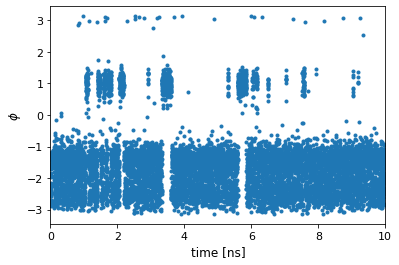

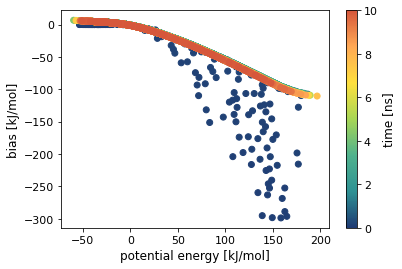

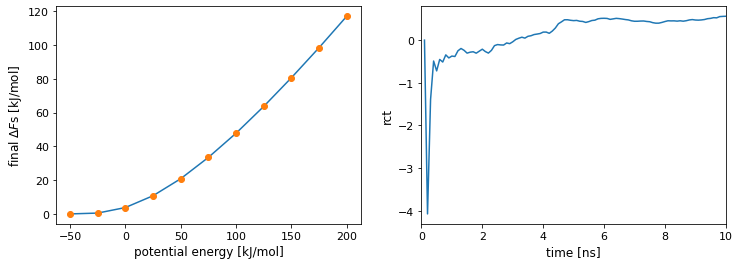

In [26]:
#plot phi
plt.plot(time, colvar['phi'], '.')
plt.ylabel('$\phi$')
plt.xlabel('time [ns]')
plt.xlim(time[0], time[-1])
plt.show()

#plot bias
plt.scatter(colvar['ene'], colvar['opes.bias'], c=time)
plt.ylabel('bias [kJ/mol]')
plt.xlabel('potential energy [kJ/mol]')
plt.colorbar(label='time [ns]')
plt.show()

#plot deltaFs
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 4))
#extract umbrella positions from the DELTAFS file, DeltaF_value
ene_values = np.array([float(val[7:]) for val in deltaFs.columns[2:] if val != 'DeltaF_P0'])
final_deltaFs = deltaFs.iloc[-1][-len(ene_values):]
final_deltaFs -= min(final_deltaFs)
axs[0].plot(ene_values, final_deltaFs)
axs[0].plot(ene_values, final_deltaFs, 'o')
axs[0].set_ylabel('final $\Delta F$s [kJ/mol]')
axs[0].set_xlabel('potential energy [kJ/mol]')
#plot rct
axs[1].plot(deltaFs['time']/1000, deltaFs['rct'])
plt.ylabel('rct')
plt.setp(axs[1], xlabel='time [ns]', xlim=(time[0], time[-1]))
plt.show()

transient = 101


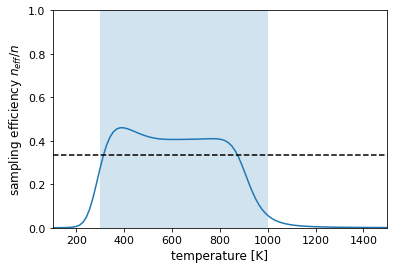

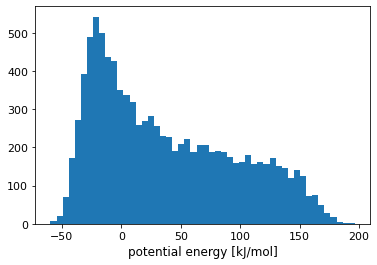

In [27]:
#plot effective sample size as a function of temperature
transient = start
print('transient =', transient)

temp_min = 300
temp_max = 1000
temp_steps = 3
temps = np.linspace(100, 1500, 100)

ESSs = np.array([calcESS((colvar['opes.bias'][transient:]+(1-T0/t)*colvar['ene'][transient:])/KBT) for t in temps])

plt.plot(temps, ESSs/(len(colvar['time'][transient:])))
plt.ylabel('sampling efficiency $n_{eff}/n$')
plt.xlabel('temperature [K]')
plt.xlim(temps[0], temps[-1])
plt.ylim(0, 1)
plt.axvspan(temp_min, temp_max, alpha=0.2)
plt.axhline(1/temp_steps, ls='--', c='k')
plt.show()

#plot the sampled energy distribution
plt.hist(colvar['ene'][transient:], bins=50)
plt.xlabel('potential energy [kJ/mol]')
plt.show()

Much better!